In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

### Data Pre-Processing

In [29]:
data = pd.read_csv('data.csv', names=['title', 'author', 'year', 'average rating', 'personal rating', 'number of pages', 'number of votes', 'dark', 'challenging', 'reflective', 'tense', 'sad'])
data.head()

,title,author,year,average rating,personal rating,number of pages,number of votes,dark,challenging,reflective,tense,sad
0,Beneath the Wheel,Hermann Hesse,1909,3.87,3.75,192,1029,0.54,0.29,0.80,0.11,0.73
1,A Grain of Wheat,Ngũgĩ wa Thiong'o,1967,3.87,3.00,247,5557,0.41,0.64,0.71,0.35,0.41
2,Milk Fed,Melissa Broder,2021,3.58,2.50,304,47350,0.35,0.25,0.57,0.12,0.25
3,Down & Out in Paris & London,George Orwell,1933,4.09,3.00,213,84225,0.38,0.22,0.76,0.05,0.29
4,The Invisible Man,H.G. Wells,1897,3.64,3.00,192,186223,0.53,0.12,0.11,0.44,0.06


In [3]:
# Standardising data (calculating and applying z-scores for each value)

numerical_data = data[['year', 'average rating', 'personal rating', 'number of pages', 'number of votes', 'dark', 'challenging', 'reflective', 'tense', 'sad']]
qualitative_data = data[['title', 'author']]
scaled_data = numerical_data

for column in scaled_data:
    values = scaled_data[column]
    mean = sum(values / len(values))
    standard_dev = np.std(values)

    for i in range(0, len(scaled_data[column])):
        scaled_data[column][i] = (scaled_data[column][i] - mean) / standard_dev

pd.DataFrame(scaled_data).head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24356\3808350369.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.7683112775032137' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scaled_data[column][i] = (scaled_data[column][i] - mean) / standard_dev
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24356\3808350369.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.6839097581270615' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scaled_data[column][i] = (scaled_data[column][i] - mean) / standard_dev
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24356\3808350369.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.48913774560872797' has dtype incompatible with int64, please explicitly 

,year,average rating,personal rating,number of pages,number of votes,dark,challenging,reflective,tense,sad
0,-1.768311,-0.148125,0.320340,-0.683910,-0.489138,-0.003234,0.111585,1.161723,-0.857035,1.957224
1,-0.264674,-0.148125,-0.296434,-0.206082,-0.484213,-0.364739,2.019941,0.863390,0.072020,0.580363
2,1.135264,-0.927501,-0.707616,0.289121,-0.438762,-0.531588,-0.106513,0.399318,-0.818324,-0.108068
3,-1.146117,0.443126,-0.296434,-0.501466,-0.398658,-0.448164,-0.270086,1.029130,-1.089298,0.064040
4,-2.079409,-0.766251,-0.296434,-0.683910,-0.287731,-0.031042,-0.815331,-1.125491,0.420415,-0.925579


### PCA (Principal Component Analysis)

In [30]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
principal_df = pd.DataFrame(data = principal_components, columns = ['pc 1', 'pc 2'])
principal_df.head()
pca.explained_variance_ratio_

array([0.26078946, 0.22035288])

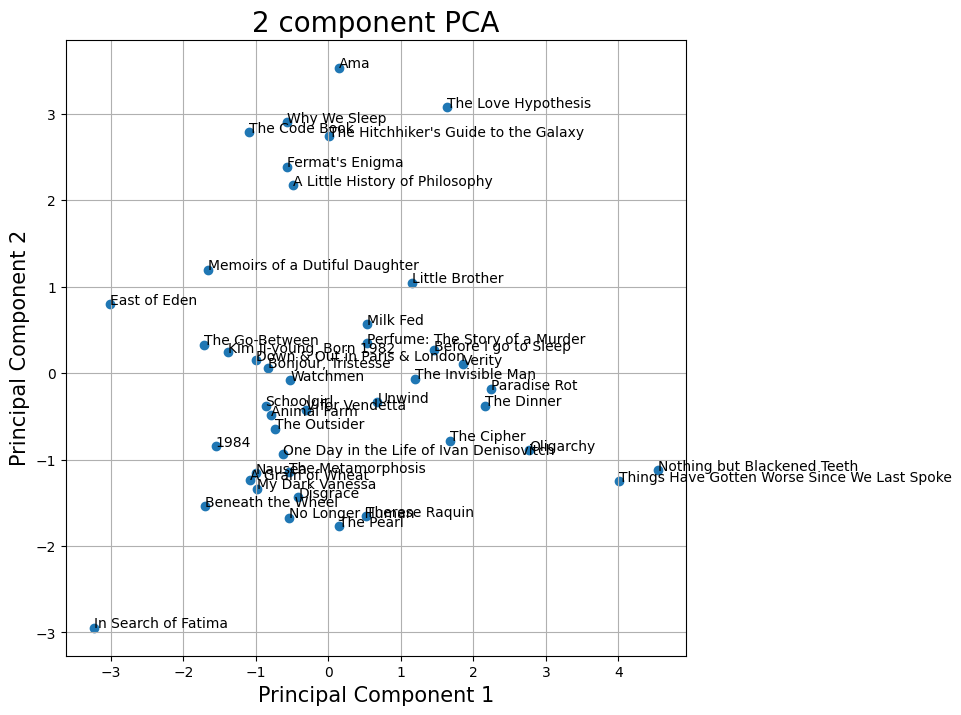

In [6]:
# Initial plot 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principal_df['pc 1'], principal_df['pc 2'])
for i, book in enumerate(qualitative_data['title']):
    ax.annotate(book, (principal_df['pc 1'][i], principal_df['pc 2'][i]))
ax.grid()

In [7]:
# Determine outliers (IQR)

def find_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    
    outliers = df[((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr)))]
    return outliers

# Calculate overall genre compatability score

genre_scores = []

for dark, challenging, reflective, tense, sad in zip(numerical_data['dark'], numerical_data['challenging'], numerical_data['reflective'], numerical_data['tense'], numerical_data['sad']):
    score = (dark + challenging + reflective + tense + sad) / 5
    genre_scores.append(score)

genre_scores = pd.DataFrame(genre_scores, columns=['score'])
outliers = find_outliers(genre_scores).dropna()

outliers

,score
19,-1.386242
32,2.001958
33,-1.318024
38,-1.308381


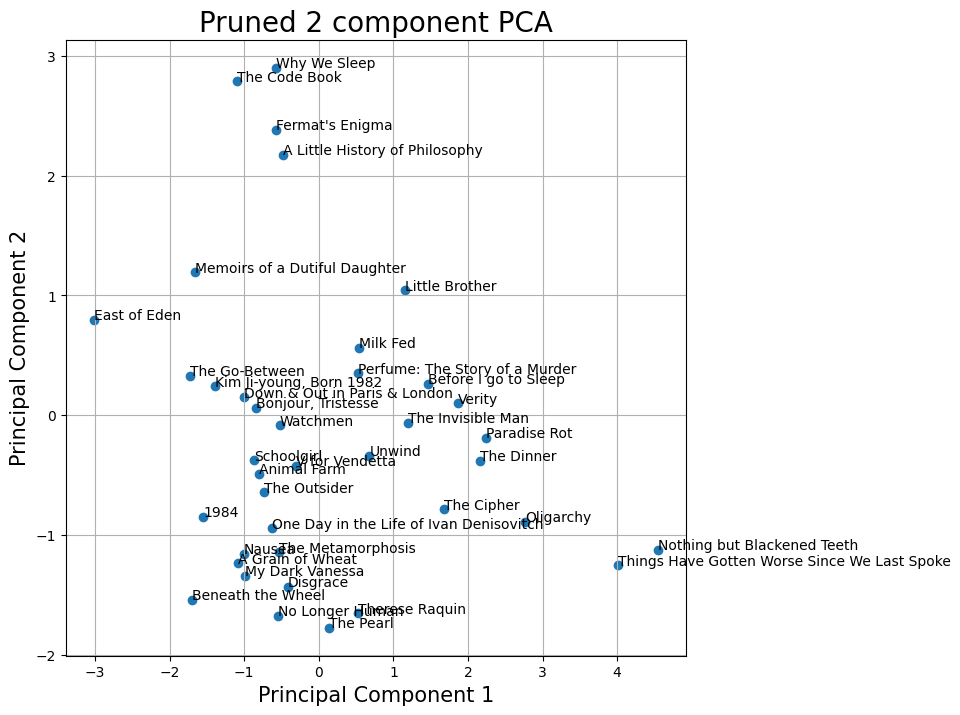

In [8]:
# Prune data

pruned_principal_df = principal_df.copy()
pruned_qualitative_data = qualitative_data.copy()

for i, row in outliers.iterrows():
    pruned_principal_df = pruned_principal_df.drop(i)
    pruned_qualitative_data = pruned_qualitative_data.drop(i)

pruned_qualitative_data = pruned_qualitative_data.reset_index(drop=True)
pruned_principal_df = pruned_principal_df.reset_index(drop=True) 

# Post pruned data plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Pruned 2 component PCA', fontsize = 20)

ax.scatter(pruned_principal_df['pc 1'], pruned_principal_df['pc 2'])
for i, book in enumerate(pruned_qualitative_data['title']):
    ax.annotate(book, (pruned_principal_df['pc 1'][i], pruned_principal_df['pc 2'][i]))
ax.grid()

## KMeans Clustering

In [9]:
# Estimate cluster centers

kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(pruned_principal_df)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['x', 'y'])

cluster_centers

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,x,y
0,-0.798506,-0.797883
1,1.909366,-0.206786
2,-1.234391,2.040684


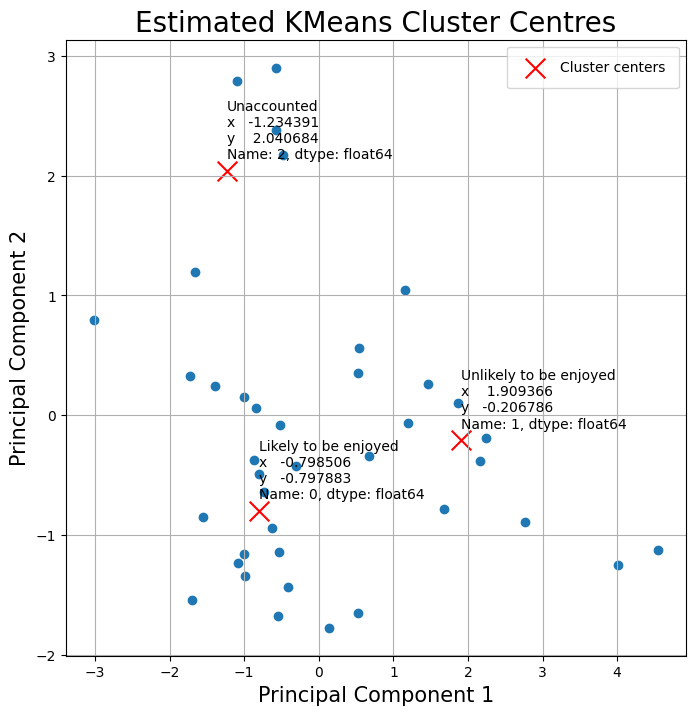

In [10]:
# Plot clusters

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Estimated KMeans Cluster Centres', fontsize = 20)

ax.scatter(pruned_principal_df['pc 1'], pruned_principal_df['pc 2'], label='_')
ax.scatter(cluster_centers['x'], cluster_centers['y'], marker='x', s=200, c='red', label='Cluster centers')
ax.legend(borderpad=1)

cluster_names = ['Likely to be enjoyed\n'+str(cluster_centers.iloc[0]), 
                 'Unlikely to be enjoyed\n'+str(cluster_centers.iloc[1]), 
                 'Unaccounted\n'+str(cluster_centers.iloc[2])]

for i, cluster in enumerate(cluster_names):
    ax.annotate(cluster, (cluster_centers['x'][i], cluster_centers['y'][i] + 0.1))

ax.grid()

In [11]:
# Calculate line intersections

def line(c1, c2):
    m = (c2[1] - c1[1]) / (c2[0] - c1[0])
    c = c2[1] - (m * c2[0])
    return [m, c]

cluster_coords = cluster_centers.to_numpy()
a, b, c = cluster_coords[0], cluster_coords[1], cluster_coords[2]
lines = [line(a,b), line(a,c), line(b,c)]

# Calculate perpendicular bisectors

def perpend_bisector(c1, c2, m):
    midpoint = [(c2[0] + c1[0]) / 2, (c2[1] + c1[1]) / 2]
    new_m = -1 / m
    new_c = midpoint[1] - (new_m * midpoint[0])
    return [new_m, new_c]

perpendicular_bisector_lines = [perpend_bisector(a,b,lines[0][0]), perpend_bisector(a,c,lines[1][0]), perpend_bisector(b,c,lines[2][0])]

# Calculate vertex of diagram

m1 = perpendicular_bisector_lines[0][0]
m2 = perpendicular_bisector_lines[1][0]
c1 = perpendicular_bisector_lines[0][1]
c2 = perpendicular_bisector_lines[1][1]

vertex_x = (c2 - c1) / (m1 - m2)
vertex_y = (m1 * vertex_x) + c1

vertex_x, vertex_y

(0.26710711619448513, 0.8185007627146965)

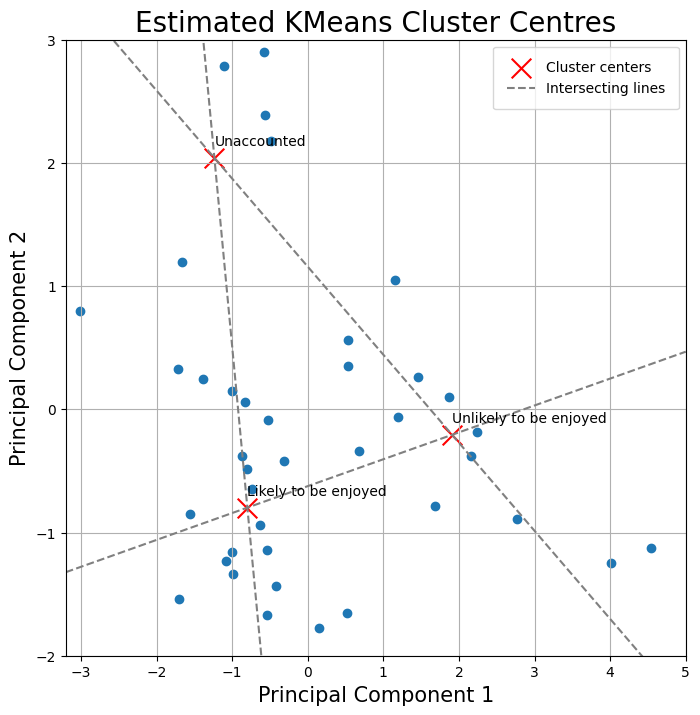

In [12]:
# Plot line intersections

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlim([-3.2, 5])
ax.set_ylim([-2, 3])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Estimated KMeans Cluster Centres', fontsize = 20)

ax.scatter(pruned_principal_df['pc 1'], pruned_principal_df['pc 2'], label='_')
ax.scatter(cluster_centers['x'], cluster_centers['y'], marker='x', s=200, c='red', label='Cluster centers')

for i, cluster in enumerate(['Likely to be enjoyed', 'Unlikely to be enjoyed', 'Unaccounted']):
    ax.annotate(cluster, (cluster_centers['x'][i], cluster_centers['y'][i] + 0.1))

x = np.linspace(-3.2, 5, 1000)
temp_lbl_check = 0
for line in lines:
    m = line[0]
    c = line[1]
    if temp_lbl_check == 0:
        ax.plot(x, m*x + c, color='gray', linestyle='dashed', label='Intersecting lines')
        temp_lbl_check += 1
    else:
        ax.plot(x, m*x + c, color='gray', linestyle='dashed', label='_')

ax.legend(borderpad=1)
ax.grid()

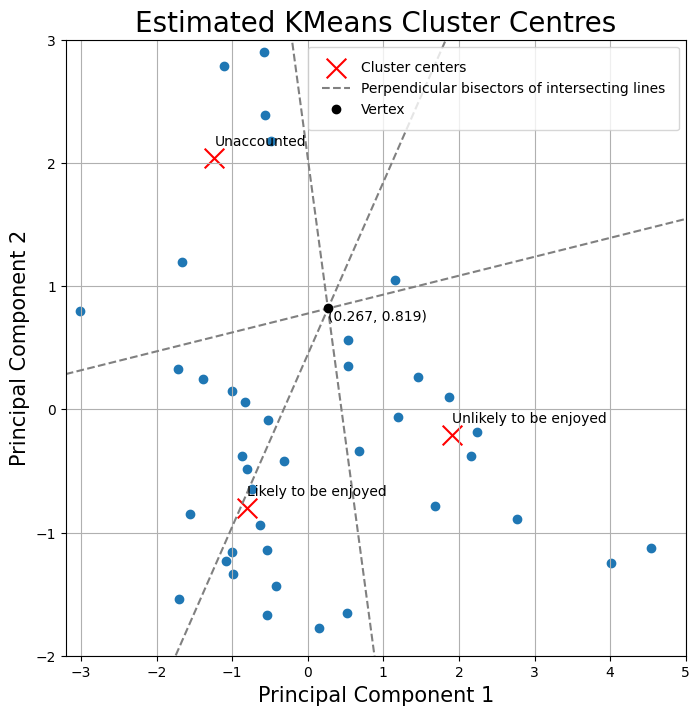

In [13]:
# Plot perpendicular bisectors
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlim([-3.2, 5])
ax.set_ylim([-2, 3])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Estimated KMeans Cluster Centres', fontsize = 20)

ax.scatter(pruned_principal_df['pc 1'], pruned_principal_df['pc 2'], label='_')
ax.scatter(cluster_centers['x'], cluster_centers['y'], marker='x', s=200, c='red', label='Cluster centers')

for i, cluster in enumerate(['Likely to be enjoyed', 'Unlikely to be enjoyed', 'Unaccounted']):
    ax.annotate(cluster, (cluster_centers['x'][i], cluster_centers['y'][i] + 0.1))

x = np.linspace(-3.2, 5, 1000)
temp_lbl_check = 0
for line in perpendicular_bisector_lines:
    m = line[0]
    c = line[1]
    if temp_lbl_check == 0:
        ax.plot(x, m*x + c, color='gray', linestyle='dashed', label='Perpendicular bisectors of intersecting lines')
        temp_lbl_check += 1
    else:
        ax.plot(x, m*x + c, color='gray', linestyle='dashed', label='_')

ax.plot(vertex_x,vertex_y, 'ko', label='Vertex')
ax.annotate(f'({vertex_x:.3}, {vertex_y:.3})', (vertex_x, vertex_y - 0.1))

ax.legend(borderpad=1, loc='upper right')
ax.grid()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24356\583918703.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24356\583918703.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.linspace(mins[1], maxs[1], 1000))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24356\583918703.py:16: FutureWarning: Series.__getite

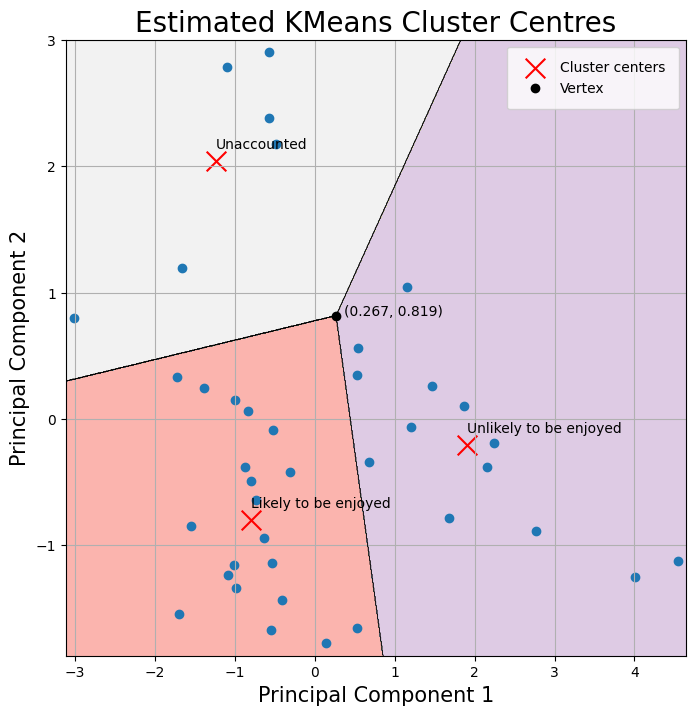

In [14]:
# Plotting Voronoi diagram

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Estimated KMeans Cluster Centres', fontsize = 20)

mins = pruned_principal_df.min(axis=0) - 0.1
maxs = pruned_principal_df.max(axis=0) + 0.1
xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),
                        np.linspace(mins[1], maxs[1], 1000))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
            cmap='Pastel1')
plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
            linewidths=0.3, colors='k')

for i, cluster in enumerate(['Likely to be enjoyed', 'Unlikely to be enjoyed', 'Unaccounted']):
    ax.annotate(cluster, (cluster_centers['x'][i], cluster_centers['y'][i] + 0.1))

ax.scatter(pruned_principal_df['pc 1'], pruned_principal_df['pc 2'], label='_')
ax.scatter(cluster_centers['x'], cluster_centers['y'], marker='x', s=200, c='red', label='Cluster centers')

ax.plot(vertex_x,vertex_y, 'ko', label='Vertex')
ax.annotate(f'({vertex_x:.3}, {vertex_y:.3})', (vertex_x + 0.1 , vertex_y))

ax.legend(borderpad=1)
ax.grid()